### In this notebook I will implement an XGBoost regressor for predicting product prices

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import dateutil.relativedelta





In [299]:
df0 = pd.read_pickle("data/data_cleaned.pkl")  

In [170]:
df0.query("StockCode == '85123A'")['UnitPrice'].unique()

array([2.55, 2.95, 3.24, 2.4 , 3.2 , 5.79])

In [90]:
df_test_1 = df0.query("StockCode == '85123A'").sort_values(by='InvoiceDate')[['InvoiceDate','UnitPrice']]

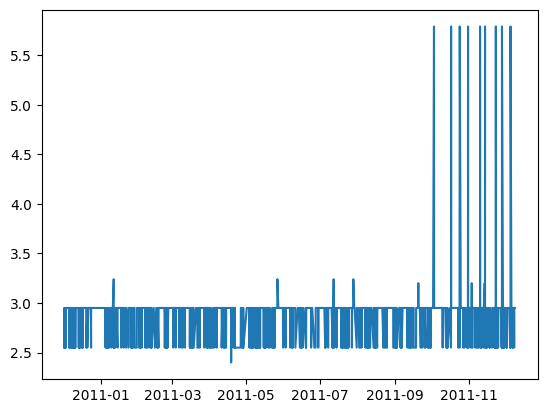

In [91]:
plt.plot(df_test_1.iloc[:,0],df_test_1.iloc[:,1] )

<Axes: xlabel='Quantity'>

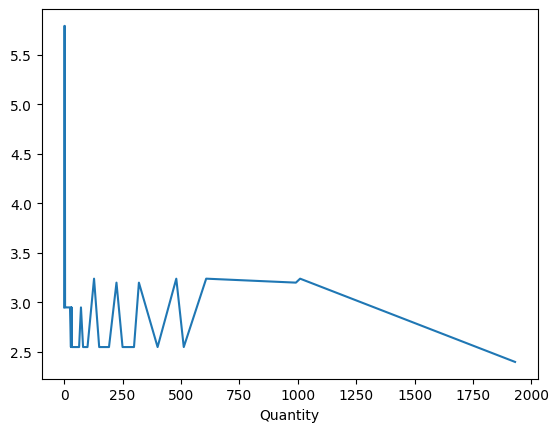

In [172]:
df0.query("StockCode == '85123A'")[['Quantity','UnitPrice' ]].groupby('Quantity')['UnitPrice'].max().plot()


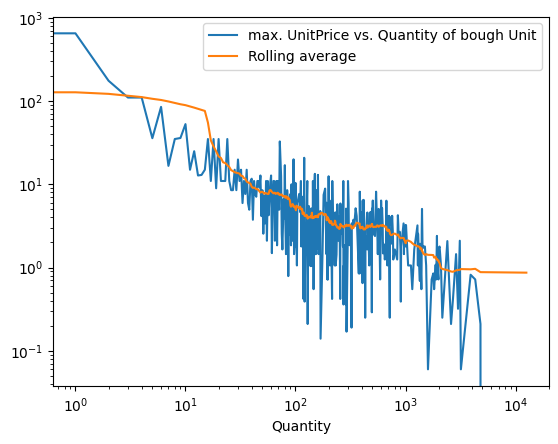

In [281]:
df0[['Quantity','UnitPrice' ]].groupby('Quantity')['UnitPrice'].max().plot()
df0[['Quantity','UnitPrice' ]].groupby('Quantity')['UnitPrice'].max().rolling(window=30,center=True,min_periods=1).mean().plot()
plt.yscale('log')
plt.xscale('log')
plt.legend(["max. UnitPrice vs. Quantity of bough Unit", "Rolling average"])


So there seems to be a correlation between the `Quantity` of bought items in a single transaction and the respective `UnitPrice`.


<Axes: xlabel='InvoiceDate'>

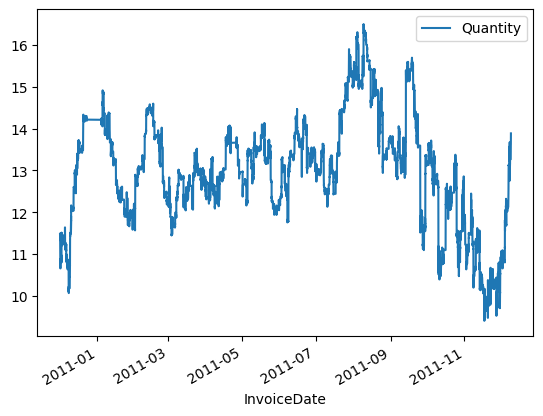

In [216]:
df0.sort_values(by='InvoiceDate')[['InvoiceDate','Quantity']].set_index('InvoiceDate').rolling(window=15000,center=True,min_periods=1).mean().plot()


In [869]:
df0.groupby('Country')['UnitPrice'].mean()

Country
Australia               2.748731
Austria                 2.984115
Bahrain                 4.644118
Belgium                 3.042817
Brazil                  4.456250
Canada                  2.397600
Channel Islands         4.152148
Cyprus                  5.236176
Czech Republic          1.594583
Denmark                 2.636376
EIRE                    3.979532
European Community      4.242105
Finland                 2.962658
France                  2.674066
Germany                 2.721027
Greece                  3.649930
Iceland                 2.644011
Israel                  3.689008
Italy                   3.739825
Japan                   2.047383
Lebanon                 5.387556
Lithuania               2.841143
Malta                   3.671468
Netherlands             2.444854
Norway                  3.271373
Poland                  3.622185
Portugal                2.548068
RSA                     4.352632
Saudi Arabia            2.351111
Singapore               3.679488
Sp

In [874]:
df0.query("StockCode == '85123A'").groupby('Country')['UnitPrice'].value_counts()

Country          UnitPrice
Australia        2.95            1
Channel Islands  2.95            4
Cyprus           2.95            3
                 2.55            2
EIRE             2.95           29
                 2.55           11
Finland          2.95            3
France           2.95            2
                 2.55            1
Germany          2.95            1
Italy            2.95            5
Malta            2.95            1
Netherlands      2.95            4
                 2.55            2
Portugal         2.95            2
Singapore        2.55            1
                 2.95            1
Spain            2.95           11
Switzerland      2.55            2
United Kingdom   2.95         1568
                 2.55          339
                 5.79            9
                 3.20            5
                 3.24            4
                 2.40            1
Name: count, dtype: int64

So, apparently, the price is not just due to differences between countries (e.g. different currencies). Unless that the currency does not depend on the `Country` of the customer but the country from which the items were ordered. Or the country of the warehous, from which the items were sent. These kinds of information are very important.

## the Model

In [818]:
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

def date_unwind(df, datecol):
    df[datecol]  = pd.to_datetime(df[datecol])
    df['month'] = df[datecol].dt.month
    #df['day'] = df[datecol].dt.day
    df['day_of_year'] = df[datecol].dt.dayofyear
    df['day_num'] = df[datecol].dt.dayofweek#+1
    return df

In [851]:
 
label_encoder = LabelEncoder() 

df1=df0.copy()
df1['StockCode'] = label_encoder.fit_transform(df1['StockCode']) 
df1['InvoiceNo'] = label_encoder.fit_transform(df1['InvoiceNo']) 
df1['CustomerID'] = label_encoder.fit_transform(df1['CustomerID']) 
df1['Country'] = label_encoder.fit_transform(df1['Country']) 


df1 = df1.drop('Description', axis=1)

df1 = date_unwind(df1, 'InvoiceDate')



In [852]:
print(df1['InvoiceDate'].min()," to ", df1['InvoiceDate'].max())

2010-12-01 08:26:00  to  2011-12-09 12:50:00


In [853]:
df1_train = df1.query("InvoiceDate<'2011-09-09'")
df1_test  = df1.query("InvoiceDate>='2011-09-09'")




X_train = df1_train.drop(['UnitPrice', 'InvoiceDate'], axis=1)
y_train = df1_train['UnitPrice']

X_test  = df1_test.drop(['UnitPrice', 'InvoiceDate'], axis=1)
y_test  = df1_test['UnitPrice']


In [854]:
X_train.head()

,InvoiceNo,StockCode,Quantity,CustomerID,Country,month,day_of_year,day_num
0,0,3233,6,4014,35,12,335,2
1,0,2643,6,4014,35,12,335,2
2,0,2847,8,4014,35,12,335,2
3,0,2795,6,4014,35,12,335,2
4,0,2794,6,4014,35,12,335,2


In [855]:
y_train.head()

0    2.55
1    3.39
2    2.75
3    3.39
4    3.39
Name: UnitPrice, dtype: float64

In [856]:
xgbr_model = xgb.XGBRegressor(objective='reg:squarederror')

## Prediction

In [857]:
xgbr_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [858]:
y_pred = xgbr_model.predict(X_test)

In [859]:
df0_test = df0.query("InvoiceDate>='2011-09-09'")

df0_pred = df0_test.copy()
df0_pred['UnitPrice'] = 0
df0_pred['UnitPrice']=y_pred

In [860]:
df0_test.sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
475796,576916,22633,HAND WARMER UNION JACK,12,2011-11-17 10:24:00,2.10,14655,United Kingdom
460245,575902,20676,RED RETROSPOT BOWL,8,2011-11-11 15:20:00,1.25,15544,United Kingdom


Text(0, 0.5, 'UnitPrice')

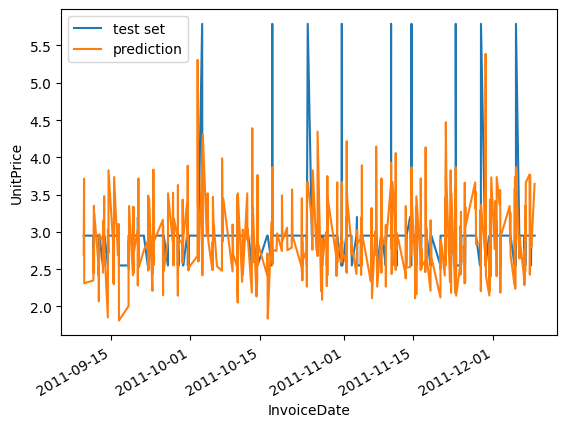

In [867]:
df0_test.query("StockCode=='85123A'").set_index('InvoiceDate')['UnitPrice'].plot()
df0_pred.query("StockCode=='85123A'").set_index('InvoiceDate')['UnitPrice'].plot()
plt.legend(["test set", "prediction"])
plt.ylabel("UnitPrice")
#plt.ylim(0,10)

In [862]:
rmse = np.sqrt(mean_squared_error(np.array(y_test), y_pred))
r2 = r2_score(np.array(y_test), y_pred)
print("RMSE: %f" % (rmse))
print("r2-score: %f" % (r2))

RMSE: 1.811473
r2-score: 0.707500


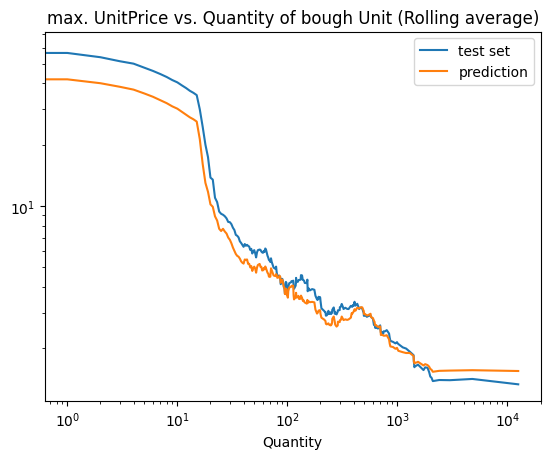

In [899]:

df0_test[['Quantity','UnitPrice' ]].groupby('Quantity')['UnitPrice'].max().rolling(window=30,center=True,min_periods=1).mean().plot()
df0_pred[['Quantity','UnitPrice' ]].groupby('Quantity')['UnitPrice'].max().rolling(window=30,center=True,min_periods=1).mean().plot()

plt.title("max. UnitPrice vs. Quantity of bough Unit (Rolling average)")
plt.yscale('log')
plt.xscale('log')
plt.legend(["test set", "prediction"])


## Conclusion

In this notebook I have implemented an XGBoost regressor for predicting the `UnitPrice` values from the given dataset.

A few points are worth noting after a brief EDA:

1. There is a noticible correlation between the `Quantity` of bought items their respective average `UnitPrice`.

2. The price is not just due to differences between countries (e.g. different currencies). Unless that the currency does not depend on the `Country` of the customer but the country from which the items were ordered. Or the country of the warehous, from which the items were sent. These kinds of information are very important.


The regression has been performed on a 9:3 (test:train) split by the `InvoiceDate` value. The regression results in an R$^2$ score of 0.71. The average prices are reproduced. However, occasional spikes are reproduced very rarely. The prediction can be improved with the following addition information:
- information about the currency or currency exchange rate associated with each transaction
- information about sales-days, rabates, quantity discount etc.
- information about the amount of stock in the warehouse (yes, some shops increase product prices shortly before the products run out of stock, as refilling the stock can take time)
- speaking of warehouses: information about the location of werehouses from which the products were shipped
- information gained from the previous notebook (product classes) or customer segmentation can also leveraged 
